Se creará una red completa, en ella se programará la dinámica combinada de Scatà et al.

Se creará una red completa con el mismo número de nodos por cada estrategia.
Cada nodo jugará el juego de la corrupción con los nodos restantes.

La dinámica debe recrear los resultados del modelo del replicador vistos en la sección 4.2


--- Iniciando simulación para Dinamarca ---
Creando red completa con 100 nodos...
Inicializando estrategias (200 C, 200 D, 200 H, 200 K)...
Iniciando 15 rondas de simulación...
Simulación completada.
Gráfica de evolución guardada como 'Resultados_Juego_Corrupcion\evolucion_dinamarca.svg'
--- Simulación para Dinamarca completada ---

--- Iniciando simulación para Singapur ---
Creando red completa con 100 nodos...
Inicializando estrategias (200 C, 200 D, 200 H, 200 K)...
Iniciando 15 rondas de simulación...
Simulación completada.
Gráfica de evolución guardada como 'Resultados_Juego_Corrupcion\evolucion_singapur.svg'
--- Simulación para Singapur completada ---

--- Iniciando simulación para México ---
Creando red completa con 100 nodos...
Inicializando estrategias (200 C, 200 D, 200 H, 200 K)...
Iniciando 15 rondas de simulación...
Simulación completada.
Gráfica de evolución guardada como 'Resultados_Juego_Corrupcion\evolucion_méxico.svg'
--- Simulación para México completada ---

Todas 

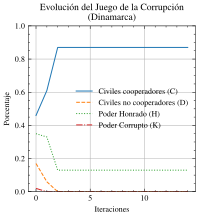

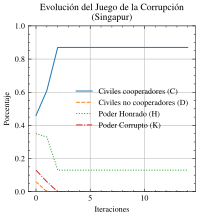


No se pudieron mostrar las gráficas: not well-formed (invalid token): line 1, column 27


In [2]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots 
import os
from collections import Counter # Para contar estrategias fácilmente

# --- Parámetros del Juego de la Corrupción ---
# (Estos se pasarán a la función de simulación)

PARAMS_DINAMARCA = {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 11, 'd': 1}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 9, 'd': 1}
#Parametros para el caso mexicano, p > q, s < q + d < p, q + d << p, 0 < c << 1
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 4.5, 'd': 4.5}

# --- Funciones Modificadas ---

def crear_red_completa(n):
    """Crea una red completa con n nodos."""
    return nx.complete_graph(n)

def inicializar_estrategias_corrupcion(n, estrategias_map=None):
    """Inicializa las 4 estrategias (C, D, H, K) equitativamente."""
    if n % 4 != 0:
        print("Advertencia: El número de nodos no es divisible por 4. La distribución no será exactamente equitativa.")

    nodos_por_estrategia = n // 4
    estrategias = {}
    nodos = list(range(n))
    random.shuffle(nodos) # Mezclar para asignación aleatoria si se prefiere, aunque aquí es secuencial

    idx = 0
    for i in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'C'
        idx += 1
    for i in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'D'
        idx += 1
    for i in range(nodos_por_estrategia):
        estrategias[nodos[idx]] = 'H'
        idx += 1
    # Los restantes son K
    while idx < n:
         estrategias[nodos[idx]] = 'K'
         idx += 1

    return estrategias

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    """Calcula el pago para el jugador i contra el jugador j en el Juego de la Corrupción."""
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']

    payoffs = {
        # (Strat_i, Strat_j): Pago_i
        ('C', 'C'): r,    ('C', 'D'): -s,   ('C', 'H'): r,    ('C', 'K'): -s,
        ('D', 'C'): t,    ('D', 'D'): 0,    ('D', 'H'): t-p,  ('D', 'K'): -p,
        ('H', 'C'): r,    ('H', 'D'): -s-c, ('H', 'H'): r,    ('H', 'K'): -s-d,
        ('K', 'C'): t,    ('K', 'D'): -c,   ('K', 'H'): t-q,  ('K', 'K'): -q-d,
    }
    return payoffs.get((strat_i, strat_j), 0) # Devuelve 0 si hay alguna combinación inesperada

def actualizar_estrategia_corrupcion(red, nodo, estrategias, recompensas_totales, K=0.1):
    """
    Actualiza la estrategia de un nodo utilizando la regla de Fermi,
    comparando su recompensa total con la de otro nodo elegido al azar.
    SIN HOMOFILIA.
    """
    estrategia_actual = estrategias[nodo]
    recompensa_total_actual = recompensas_totales[nodo]

    # Elegir OTRO nodo al azar (cualquiera en la red completa)
    posibles_vecinos = [n for n in red.nodes() if n != nodo]
    if not posibles_vecinos: # Si solo hay un nodo
         return estrategia_actual
    otro_nodo = random.choice(posibles_vecinos)

    estrategia_otro = estrategias[otro_nodo]
    recompensa_total_otro = recompensas_totales[otro_nodo]

    # Aplicar regla de Fermi (simplificada, sin homofilia)
    try:
        if K <= 1e-9: # Evitar división por cero o K muy pequeño
             probabilidad_adoptar = 1.0 if recompensa_total_otro > recompensa_total_actual else 0.0
        else:
            # Escalar diferencia para evitar overflow en exp()
            delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_otro) / K, -700, 700)
            probabilidad_adoptar = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError):
         # Si aún así hay error, adoptar la estrategia con mayor recompensa
        probabilidad_adoptar = 1.0 if recompensa_total_otro > recompensa_total_actual else 0.0


    if random.random() < probabilidad_adoptar:
        return estrategia_otro
    else:
        return estrategia_actual

def ejecutar_simulacion_corrupcion(
    num_nodos=800,
    params_juego=PARAMS_MEXICO, # Parámetros de la matriz de pagos
    K=0.001, # Nivel de ruido/incertidumbre en la adopción
    rondas=15,
    seed=None
    ):
    """
    Ejecuta la simulación del Juego de la Corrupción en una red completa.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    print(f"Creando red completa con {num_nodos} nodos...")
    red = crear_red_completa(num_nodos)
    print("Inicializando estrategias (200 C, 200 D, 200 H, 200 K)...")
    estrategias = inicializar_estrategias_corrupcion(num_nodos)

    # Diccionario para guardar la historia de las fracciones de cada estrategia
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}
    nodos_lista = list(red.nodes()) # Lista de nodos para eficiencia

    print(f"Iniciando {rondas} rondas de simulación...")
    for r in range(rondas):
        # 1. Calcular recompensas totales para todos los nodos
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for i_idx, nodo_i in enumerate(nodos_lista):
            strat_i = estrategias[nodo_i]
            # Juega contra todos los demás
            for j_idx, nodo_j in enumerate(nodos_lista):
                if i_idx == j_idx:
                    continue # No juega contra sí mismo
                strat_j = estrategias[nodo_j]
                recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)

        # 2. Intentar actualizar estrategia para cada nodo (guardar en dict temporal)
        siguientes_estrategias = {}
        for nodo in nodos_lista:
            siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion(
                red, nodo, estrategias, recompensas_totales, K
            )

        # 3. Aplicar las nuevas estrategias para la siguiente ronda
        estrategias = siguientes_estrategias

        # 4. Registrar fracción de cada estrategia
        conteo_actual = Counter(estrategias.values())
        for strat in ['C', 'D', 'H', 'K']:
            historia_fracciones[strat].append(conteo_actual.get(strat, 0) / num_nodos)

        # Opcional: Imprimir progreso cada X rondas
        if (r + 1) % 50 == 0:
             print(f"  Ronda {r+1}/{rondas} completada.")
             # print(f"    Fracciones: C={historia_fracciones['C'][-1]:.2f}, D={historia_fracciones['D'][-1]:.2f}, H={historia_fracciones['H'][-1]:.2f}, K={historia_fracciones['K'][-1]:.2f}")


    print("Simulación completada.")
    return historia_fracciones

def graficar_evolucion_corrupcion(historia_fracciones, titulo, filename):
    """Grafica la evolución de las 4 estrategias a lo largo del tiempo."""
    plt.style.use(['science', 'ieee']) # Estilo de gráfica científica
    plt.figure(figsize=(3, 3)) # Tamaño ajustado para 4 líneas

    colores = {'C': '#1f77b4', 'D': '#ff7f0e', 'H': '#2ca02c', 'K': '#d62728'} # Colores distintivos
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'} # Estilos de línea distintivos
    nombres_legenda = {
        'C': 'Civiles cooperadores (C)',
        'D': 'Civiles no cooperadores (D)',
        'H': 'Poder Honrado (H)',
        'K': 'Poder Corrupto (K)'
    }


    rondas_totales = len(historia_fracciones['C']) # Asumiendo que todas tienen la misma longitud
    eje_x = range(rondas_totales)

    for strat in ['C', 'D', 'H', 'K']:
        plt.plot(
            eje_x,
            historia_fracciones[strat],
            label=nombres_legenda[strat],
            color=colores[strat],
            linestyle=estilos[strat]
        )

    plt.xlabel("Iteraciones")
    plt.ylabel("Porcentaje")
    plt.title(f"Evolución del Juego de la Corrupción\n({titulo})")
    plt.ylim(0, 1) # Eje Y entre 0 y 1 (o 0 y 0.8/0.5 si prefieres como en tu tesis)
    plt.legend(fontsize='medium') # Leyenda más legible
    plt.grid(True)

    # Guardar la gráfica
    os.makedirs(os.path.dirname(filename), exist_ok=True) # Crear directorio si no existe
    plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight')
    print(f"Gráfica de evolución guardada como '{filename}'")
    plt.close() # Cerrar la figura para liberar memoria


# --- Función Principal para Ejecutar y Graficar ---

def simular_y_graficar_pais(nombre_pais, params_juego, num_nodos=800, K=0.1, rondas=200, seed=None, output_dir="Resultados_Corrupcion"):
    """Ejecuta la simulación para un 'país' (conjunto de parámetros) y guarda la gráfica."""

    print(f"\n--- Iniciando simulación para {nombre_pais} ---")
    historia = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos,
        params_juego=params_juego,
        K=K,
        rondas=rondas,
        seed=seed
    )

    nombre_archivo_grafica = os.path.join(output_dir, f"evolucion_{nombre_pais.lower().replace(' ', '_')}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, nombre_archivo_grafica)
    print(f"--- Simulación para {nombre_pais} completada ---")
    return historia

# --- Ejemplo de Uso ---

if __name__ == "__main__":
    # Parámetros globales de simulación
    NODOS = 100
    RUIDO_K = 0.00000 # Puedes experimentar con este valor, similar a Scatà et al. (K=0.5) o más bajo
    RONDAS = 15 # Ajusta según necesites para ver convergencia
    SEED_GLOBAL = 1 # Para reproducibilidad
    OUTPUT_DIR_GLOBAL = "Resultados_Juego_Corrupcion"

    # Ejecutar para cada país
    historia_dinamarca = simular_y_graficar_pais("Dinamarca", PARAMS_DINAMARCA, NODOS, RUIDO_K, RONDAS, SEED_GLOBAL, OUTPUT_DIR_GLOBAL)
    historia_singapur = simular_y_graficar_pais("Singapur", PARAMS_SINGAPUR, NODOS, RUIDO_K, RONDAS, SEED_GLOBAL, OUTPUT_DIR_GLOBAL)
    historia_mexico = simular_y_graficar_pais("México", PARAMS_MEXICO, NODOS, RUIDO_K, RONDAS, SEED_GLOBAL, OUTPUT_DIR_GLOBAL)

    print(f"\nTodas las simulaciones completadas. Resultados guardados en '{OUTPUT_DIR_GLOBAL}'.")

    # Opcional: Mostrar las gráficas si estás en un entorno como Jupyter
    try:
        from IPython.display import SVG, display
        print("\nMostrando gráficas generadas:")
        display(SVG(os.path.join(OUTPUT_DIR_GLOBAL, "evolucion_dinamarca.svg")))
        display(SVG(os.path.join(OUTPUT_DIR_GLOBAL, "evolucion_singapur.svg")))
        display(SVG(os.path.join(OUTPUT_DIR_GLOBAL, "evolucion_mexico.svg")))
    except ImportError:
        print("\n(Instala IPython para ver las gráficas directamente aquí si estás en un notebook).")
    except Exception as e:
        print(f"\nNo se pudieron mostrar las gráficas: {e}")
